**Sprint 3: Model Development**

In [3]:
#Dependencies
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, roc_auc_score
from xgboost import cv
from optuna import create_study
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history, plot_param_importances
import optuna
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**Load the data**

In [4]:
# Load compressed datasets from .npz files
X_test = sparse.load_npz("../data/X_test_sparse.npz")
X_train = sparse.load_npz("../data/X_train_sparse.npz")
y_train = np.load("../data/y_train.npy")

Split the training data into 2 sets: training and validation. We use TimeSeriesSplit for time-aware cross-validation. TimeSeriesSplit returns the first k folds as the train set, while using the k+1-th set as the valid set. This allows the model to be validated against future observations least like those that are used to train the model.

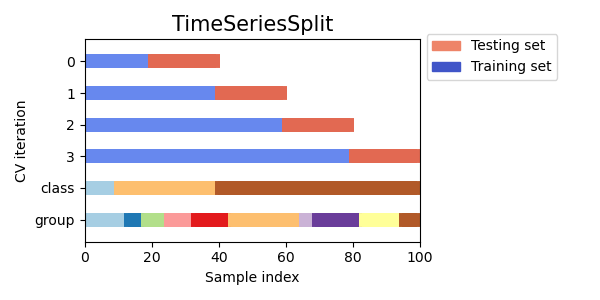

(Note that the index is sorted by time)

In [5]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
train_idx, valid_idx = splits[-1]
X_tr, X_val = X_train[train_idx], X_train[valid_idx]
y_tr, y_val = y_train[train_idx], y_train[valid_idx]

We propose a list of potential classifiers. I only chose 5, because of hardware constraints.

In [6]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=5000)),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Extra Trees", ExtraTreesClassifier()),
    ("Bagging", BaggingClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("SVC", SVC(probability=True)),
    ("KNN", KNeighborsClassifier()),
]

For each classifier:
- Fit on train data
- Generate predictions on validation data
- Graph the predicted values and ground truths on a Receiver Operating Characteristic (ROC) curve

Receiver Operating Characteristic (ROC) curve graphs the true positive rate against false positive rate. Large discrepencies between validation and training ROC curves are evidences for overfitting.
<p align = "center">
<img src="../notebooks/static/roc_curve.png" width="600"/>
<p>

Note that C is not a bad classifier, as the predictions only needs to be reversed to get the same accuracy as C'

Warning: The cell belows takes >60 minutes to run. The entire cell will be commented when one of the classifiers is chosen for further tuning.

In [7]:
#plt.figure(figsize=(10, 8))
#for name, clf in classifiers[:10]:
#    try:
#        clf.fit(X_tr, y_tr)
#        if hasattr(clf, "predict_proba"):
#            y_score = clf.predict_proba(X_val)[:, 1]
#        else:
#            y_score = clf.decision_function(X_val)
#        fpr, tpr, _ = roc_curve(y_val, y_score)
#        roc_auc = auc(fpr, tpr)
#        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
#    except Exception as e:
#        print(f"Skipped {name}: {e}")
#
#plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('ROC Curves for Classifiers')
#plt.legend(loc="lower right")
#plt.tight_layout()
#plt.show()

Resulting graph:
<p align = "center">
<img src="../notebooks/static/classifiers_roc_curves.png" width="1000"/>
<p>

The most promising model is LogisticRegression

In [8]:
# Fit a simple logistic regression to get feature importances
clf = LogisticRegression(solver='saga', penalty='l2', max_iter=5000, random_state=42, n_jobs=-1, class_weight='balanced')
clf.fit(X_tr, y_tr)

importances = np.abs(clf.coef_).flatten()
importances_indices = np.where(importances > 0.005)[0]

KeyboardInterrupt: 

In [ ]:
importances = np.abs(clf.coef_).flatten()

In [ ]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_int('max_iter', 100, 5000)

    clf = LogisticRegression(
        solver='liblinear',
        penalty=penalty,
        max_iter=max_iter,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    # Use the selected features datasets
    X_tr_small = X_tr[:1000]
    y_tr_small = y_tr[:200]
    X_val_small = X_val[:200]
    y_val_small = y_val[:200]
    clf.fit(X_tr_small, y_tr_small)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val_small)[:, 1]
    else:
        y_score = clf.decision_function(X_val_small)
    score = roc_auc_score(y_val_small, y_score)

    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score

pruner = MedianPruner(n_startup_trials=2, n_warmup_steps=0)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-22 20:54:34,087] A new study created in memory with name: no-name-019e29ef-f301-4a38-9ab8-5e5df7643bcf
C:\Users\admin\AppData\Local\Temp\ipykernel_7448\2307429331.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-06-22 21:08:43,642] Trial 0 finished with value: 0.9320590591306682 and parameters: {'C': 4.099254685789053, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 4158}. Best is trial 0 with value: 0.9320590591306682.
C:\Users\admin\AppData\Local\Temp\ipykernel_7448\2307429331.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[W 2025-06-22 21:08:43,646] Tri

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'l1', 'l2', 'elasticnet'} or None. Got 'none' instead.